<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загружу необходимые библиотеки.

In [1]:
!pip install wordcloud

     |████████████████████████████████| 458 kB 1.7 MB/s eta 0:00:01


In [2]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

Сохраню датасет в переменную df.

In [3]:
try:  
    df = pd.read_csv('C:/project/toxic_comments.csv')
except OSError as e:
    df = pd.read_csv('/datasets/toxic_comments.csv')
display(df.head(10))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Таблица представляет собой столбец с тестом для анализа и столбец с целевым признаком.

Посмотрю на общую информацию по данным.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


С типами данных всё в порядке, пропусков нет.

Посмотрю на соотношение 1 и 0 в целевом признаке.

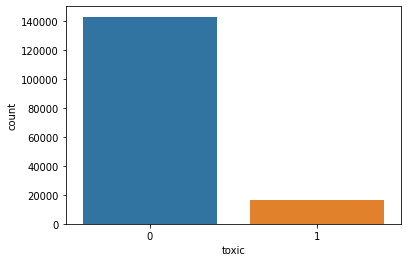

In [5]:
sns.countplot(x = 'toxic', data = df);

Данные несбалансированны, посмотрю во сколько раз нулей больше чем единиц.

In [6]:
display(df['toxic'].value_counts())
ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print(ratio)

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229


Нулей почти в девять раз больше чем единиц.

Визуализирую самые частые слова в тексте.

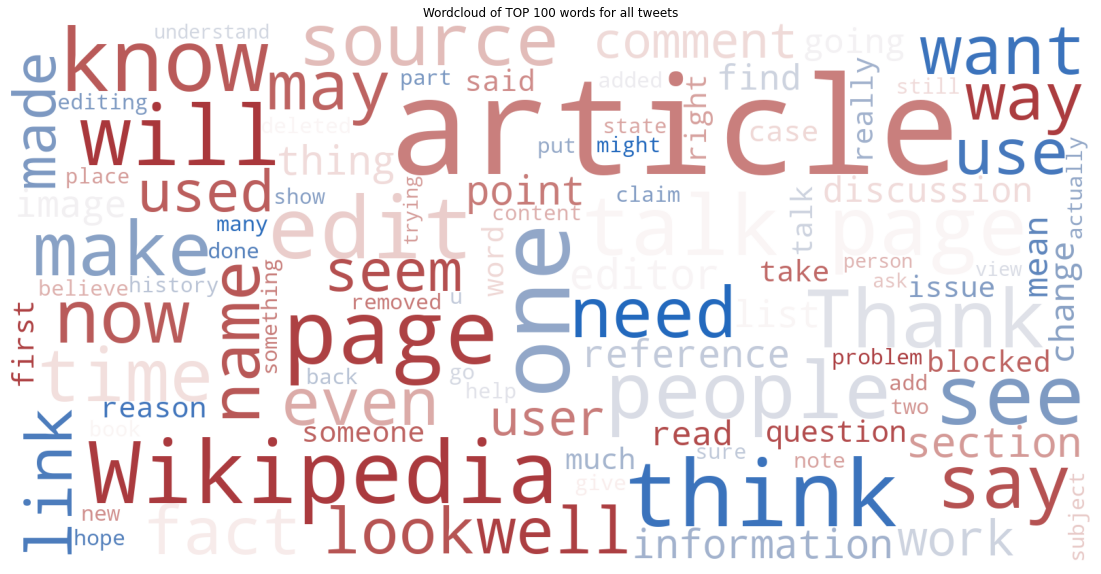

In [7]:
df_bad = df[df['toxic']==1]
df_good = df[df['toxic']==0]

bad_good = " ".join(review for review in df.text)
bad = " ".join(review for review in df_bad.text)
good = " ".join(review for review in df_good.text)

def cloud(text):
    wordcloud = WordCloud(width=1600,
                          height=800,
                          max_font_size=200,
                          max_words=100,
                          colormap='vlag',
                          background_color="white",
                          collocations=True).generate(text)

    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.title('Wordcloud of TOP 100 words for all tweets')
    plt.axis("off")
    plt.show()
    
cloud(bad_good)

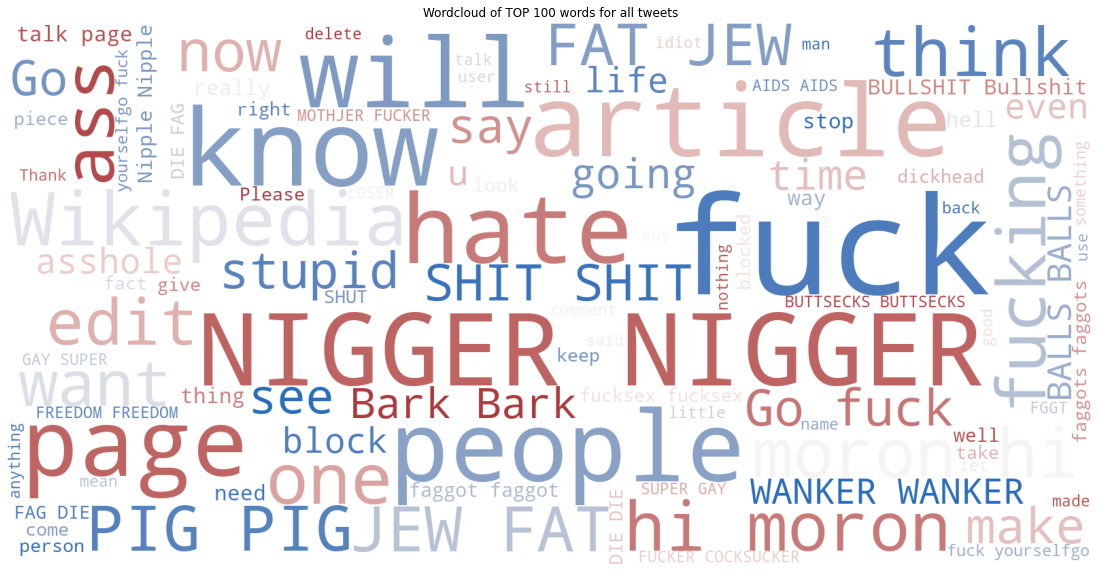

In [8]:
cloud(bad)

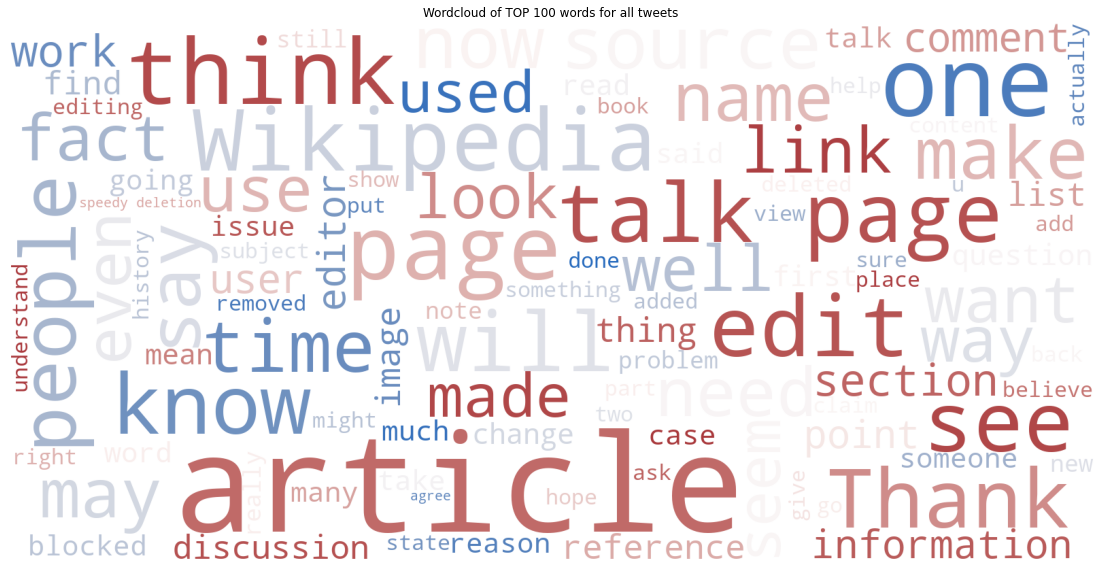

In [9]:
cloud(good)

Подготовлю признаки перед обучением.

Проведу лемматизацию текста.

In [10]:
def clean_text(text):
    text = text.lower()
    return text

In [11]:
%%time
df['text'] = df['text'].map(lambda x: clean_text(x))

CPU times: user 184 ms, sys: 8 ms, total: 192 ms
Wall time: 193 ms


In [12]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop_words_eng  = set(stopwords.words('english'))
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [13]:
%%time

punctuation = u",.?!()-_\"\'\\\n\r\t;:+*<>@#§^$%&|/"
stop_words_eng = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tag_dict = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

def extract_wnpostag_from_postag(tag):
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(tupla):
    tag = extract_wnpostag_from_postag(tupla[1])    
    return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]

def bag_of_words(sentence, stop_words=None):
    if stop_words is None:
        stop_words = stop_words_eng
    original_words = word_tokenize(sentence)
    tagged_words = nltk.pos_tag(original_words)
    original_words = None
    lemmatized_words = [ lemmatize_tupla_word_postag(ow) for ow in tagged_words ]
    tagged_words = None
    cleaned_words = ' '.join([ w for w in lemmatized_words if (w not in punctuation) and (w not in stop_words) ])
    lemmatized_words = None
    return cleaned_words

df['pos'] = df['text'].apply(lambda x: bag_of_words(x))

CPU times: user 9min 8s, sys: 3.89 s, total: 9min 11s
Wall time: 9min 12s


In [14]:
display(df.head(15))
display(df.tail(15))

,Unnamed: 0,text,toxic,pos
0,0,explanation\nwhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,1,d'aww! he matches this background colour i'm s...,0,d'aww match background colour 'm seemingly sti...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man 'm really try edit war 's guy constant...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,`` ca n't make real suggestion improvement won...
4,4,"you, sir, are my hero. any chance you remember...",0,sir hero chance remember page 's
5,5,"""\n\ncongratulations from me as well, use the ...",0,`` congratulation well use tool well · talk ``
6,6,cocksucker before you piss around on my work,1,cocksucker piss around work
7,7,your vandalism to the matt shirvington article...,0,vandalism matt shirvington article revert plea...
8,8,sorry if the word 'nonsense' was offensive to ...,0,sorry word 'nonsense offensive anyway 'm inten...
9,9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


,Unnamed: 0,text,toxic,pos
159277,159436,"i'll be on irc, too, if you have a more specif...",0,'ll irc specific request
159278,159437,it is my opinion that that happens to be off-t...,0,opinion happen off-topic believe never claim c...
159279,159438,please stop removing content from wikipedia; i...,0,please stop remove content wikipedia consider ...
159280,159439,image:barack-obama-mother.jpg listed for delet...,0,image barack-obama-mother.jpg list deletion im...
159281,159440,"""editing of article without consensus & remova...",0,`` editing article without consensus removal c...
159282,159441,"""\nno he did not, read it again (i would have ...",0,`` read would think everyone could recite hear...
159283,159442,"""\n auto guides and the motoring press are not...",0,`` auto guide motoring press good source encyc...
159284,159443,"""\nplease identify what part of blp applies be...",0,`` please identify part blp applies blp clearl...
159285,159444,catalan independentism is the social movement ...,0,catalan independentism social movement involve...
159286,159445,the numbers in parentheses are the additional ...,0,number parenthesis additional decimal point me...


Разобью выборку на тренировочную, валидационную и тестовую.

In [15]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words_eng)

features_train = count_tf_idf.fit_transform(features_train['pos'])
features_valid = count_tf_idf.transform(features_valid['pos'])
features_test = count_tf_idf.transform(features_test['pos'])

print(features_train.shape[0])
print(features_valid.shape[0])
print(features_test.shape[0])

95575
31858
31859


Данные подготовленны для обучения моделей.

## Обучение

Начну обучение с модели линейной регрессии.

In [17]:
model = LogisticRegression()
lr_f1 = cross_val_score(model,
                      features_train, 
                      target_train, 
                      cv=5, 
                      scoring='f1').mean()
print('F1 =', lr_f1)

F1 = 0.6908780595049673


Уменьшу количество частых классов.

In [18]:
bad_index = df.iloc[target_train.index]

bad_index_zero = bad_index[bad_index['toxic'] == 0]['toxic']
bad_index_one = bad_index[bad_index['toxic'] == 1]['toxic']

In [19]:
bad_index_zero_downsample = bad_index_zero.sample(bad_index_one.shape[0], random_state=12345)

target_train_downsample = pd.concat([bad_index_zero_downsample, bad_index_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)

features_train_downsample = count_tf_idf.transform(features_train_downsample['pos'])

In [20]:
model = LogisticRegression()
train_f1_downsampled = cross_val_score(model,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=5, 
                      scoring='f1').mean()
print('F1 =', train_f1_downsampled)

F1 = 0.883553384207844


Наибольшее значение метрики F1 я получил после уменьшения количества частых классов.

Подберу наилучшие гиперпараметры для логистической регрессии.

In [21]:
%%time

model = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}]

clf = GridSearchCV(model, hyperparams, scoring='f1', cv=5)
clf.fit(features_train_downsample, target_train_downsample)
print(clf.best_params_)

{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
CPU times: user 3min 18s, sys: 3min 45s, total: 7min 4s
Wall time: 7min 4s


Рассчитаю метрику f1 для валидационной выборки.

In [22]:
%%time

model = LogisticRegression()
model.set_params(C = 10, class_weight = 'balanced', solver = 'lbfgs')
model.fit(features_train_downsample, target_train_downsample)
predict = model.predict(features_valid)
f1_score_logistic = f1_score(target_valid, predict)
print('F1 =', f1_score_logistic)

F1 = 0.6911590424271153
CPU times: user 14.2 s, sys: 17.5 s, total: 31.7 s
Wall time: 31.7 s


Рассчитаю метрику f1 для CatBoostClassifier.

In [23]:
%%time

model = CatBoostClassifier(verbose=False, iterations=200)
model.fit(features_train_downsample, target_train_downsample)
f1_score = cross_val_score(model,
                            features_train_downsample, 
                            target_train_downsample, 
                            cv=5, 
                            scoring='f1').mean()
print('F1 =', f1_score)

F1 = 0.8690589699586864
CPU times: user 7min 54s, sys: 40.3 ms, total: 7min 54s
Wall time: 7min 59s


Рассчитаю метрику f1 для CatBoostClassifier на валидационной выборке.

In [24]:
%%time

model = CatBoostClassifier(verbose=False, iterations=200)
model.fit(features_train_downsample, target_train_downsample)
f1_score_2 = cross_val_score(model,
                           features_valid, 
                           target_valid, 
                           cv=5, 
                           scoring='f1').mean()
print('F1 =', f1_score_2)

F1 = 0.706336719508984
CPU times: user 11min 14s, sys: 0 ns, total: 11min 14s
Wall time: 11min 21s


Вычислю метрику f1 для тестовой выборки.

Объединю тренировочную и валидационную выборки.

In [25]:
target_all = pd.concat([target_train, target_valid], ignore_index=True)

Уменьшу количество частых классов.

In [26]:
bad_index_2 = df.iloc[target_all.index]

bad_index_zero_2 = bad_index_2[bad_index_2['toxic'] == 0]['toxic']
bad_index_one_2 = bad_index_2[bad_index_2['toxic'] == 1]['toxic']

In [27]:
bad_index_zero_downsample_2 = bad_index_zero_2.sample(bad_index_one_2.shape[0], random_state=12345)

target_train_downsample_2 = pd.concat([bad_index_zero_downsample_2, bad_index_one_2])

features_train_downsample_2 = df.iloc[target_train_downsample_2.index]
features_train_downsample_2, target_train_downsample_2 = shuffle(features_train_downsample_2,
                                                                 target_train_downsample_2,
                                                                 random_state=12345)

features_train_downsample_2 = count_tf_idf.transform(features_train_downsample_2['pos'])

Рассчитаю метрику f1 для тестовой выборки на модели логистической регрессии.

In [28]:
%%time

model = LogisticRegression()
model.set_params(C = 10, class_weight = 'balanced', solver = 'lbfgs')
model.fit(features_train_downsample_2, target_train_downsample_2)
predict = model.predict(features_test)
f1_score_3 = f1_score(target_test, predict)
print('F1 =', f1_score_3)

TypeError: 'numpy.float64' object is not callable

Рассчитаю метрику f1 для тестовой выборки на модели CatBoostClassifier.

In [29]:
%%time

model = CatBoostClassifier(verbose=False, iterations=200)
model.fit(features_train_downsample_2, target_train_downsample_2)
predict = model.predict(features_test)
f1_score_4 = f1_score(target_test, predict)
print('F1 =', f1_score_4)

TypeError: 'numpy.float64' object is not callable

Подберу гиперпараметры вручную.

In [30]:
%%time

model = CatBoostClassifier(verbose=False, iterations=500)
model.fit(features_train_downsample_2, target_train_downsample_2)
predict = model.predict(features_test)
f1_score_5 = f1_score(target_test, predict)
print('F1 =', f1_score_5)

TypeError: 'numpy.float64' object is not callable

In [31]:
model = SGDClassifier()
model.set_params(class_weight = 'balanced', eta0 = 0.2, learning_rate = 'adaptive', loss = 'modified_huber', random_state = 12345)
model.fit(features_train_downsample_2, target_train_downsample_2)
target_predict = model.predict(features_test)
f1_SGDC = f1_score(target_test, target_predict)
print(f1_SGDC)

TypeError: 'numpy.float64' object is not callable

In [ ]:
%%time

model = LogisticRegression(class_weight = 'balanced')
model.set_params(C = 10, solver = 'lbfgs')
model.fit(features_train, target_train)
predict = model.predict(features_test)
f1_score_3 = f1_score(target_test, predict)
print('F1 =', f1_score_3)

## Выводы

Наилучшее значение метрики F1 = 0,7414 показала модель CatBoostClassifier с гиперпараметрами: verbose=False, iterations=500.